In [1]:
# Cell 0: Setup and Imports
import numpy as np
import pandas as pd
import os
import sys
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
from tqdm import tqdm
tqdm.pandas(leave=False)

# Display settings
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500) 
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)

from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import our clean study analysis script
from utils.clean_study_analysis import run_multi_epoch_analysis

print("🔧 Notebook initialized - Ready for multi-epoch study analysis!")


🔧 Notebook initialized - Ready for multi-epoch study analysis!


In [2]:
df_study = pd.read_parquet('/media/data1/datasets/DeepCoro/2b_CathReport_HEMO_MHI_MERGED_2017-2024_STUDY_LEVEL.parquet')
display(df_study.head(n=1))

,EXAMEN_ID,CathReport_MRN,Num Accession,DICOMPath,ModalitiesInStudy,Patient_ID,QueryRetrieveLevel,StudyDate,StudyInstanceUID,StudyTime,year,patient_id_anon,dicom_id_x,study_time,series_time,IDPATIENT,DATEEXAMEN,TYPEEXAMEN,CATEGORIE,SOUSCATEGORIE,TITREEXAMEN,HEUREDEBUT,HEUREFIN,SALLE,NSEJOUR,FACTIVE,TYPEPROVENANCE,POIDS,TAILLE,HOSPITAL,Urgency,CREATININE,CK,HEMOGLOBINE,PLAQUETTES,TNI,TROPHS,ANGINA,ISCHEMIA,LOCALISATIONISCHEMIE,LV,DIABETES_HISTORY,HYPERTENSION,SMOKING,CAD_HISTORY,OTHERSURGERY,STROKE,VASCULAR,FIBRILLATION,TV,PM,CABG,LV.1,LVEF,RENAL,VASCULARACCESS,VASCULARACCESS2,FERMETUREART,FERMETUREART2,VEINACCESS,VEINACCESS2,FERMETUREVEIN,FERMETUREVEIN2,METHERGIN,LAO,RAO,STENTS,BMS,BALLONS,TRONC0,TRONC50,IVA50,CX50,CD50,PONTAGES,TC50,LESIONRESTENOSE,STENTSACTIFRESTENOSE,STENTSRESTENOSE,PONTAGESMAMMAIRES50,PONTAGESSAPHENES50,DILATATIONS,DILATATIONSPONTAGESSUCCES,TCDILATATIONS,PONTAGESSAPHENES,LESIONSSTENTSACTIF,DILATATIONSPONTAGESECHEC,DILATATIONSSUCCES,DILATATIONSECHEC,LESIONSSTENTS,STENTSACTIFS,PONTAGESMAMMAIRES,PONTAGES50,BVS,CDBMS,CDBVS,CDDEB,CDDILATATIONS,CDSTENTS,CDSTENTSACTIF,CIRCRESTENOSE,CXBMS,CXBVS,CXDEB,CXDILATATIONS,CXSTENTS,CXSTENTSACTIF,DEB,DILATATIONSPONTAGES,DSTENTMAX,DSTENTMIN,DSTENTMOY,GRAFTRESTENOSE,GUIDEPRESSION,IVABMS,IVABVS,IVADEB,IVADILATATIONS,IVASTENTS,IVASTENTSACTIF,IVUS,LADRESTENOSE,LESIONS50,LESIONSDILATATIONS,LMRESTENOSE,LSTENT,LSTENTMAX,LSTENTMIN,PONTAGESBMS,PONTAGESBVS,PONTAGESDEB,PONTAGESDILATATIONS,PONTAGESPERMEABLES,PONTAGESSTENTS,PONTAGESSTENTSACTIFS,RCARESTENOSE,SYNTAX,TCBMS,TCBVS,TCDEB,TCSTENTS,TCSTENTSACTIF,TRONCRESTENOSE,Indications,Recommendation,Conclusion,D1_stenosis,D2_stenosis,D3_stenosis,RVG1_stenosis,RVG2_stenosis,S1_stenosis,bx_stenosis,dist_lad_stenosis,dist_lcx_stenosis,dist_rca_stenosis,left_main_stenosis,lima_or_svg_stenosis,lvp_stenosis,mid_lad_stenosis,mid_lcx_stenosis,mid_rca_stenosis,om1_stenosis,om2_stenosis,om3_stenosis,pda_stenosis,posterolateral_stenosis,prox_lad_stenosis,prox_lcx_stenosis,prox_rca_stenosis,right_marginal_stenosis,D1_IFRHYPER,D2_IFRHYPER,D3_IFRHYPER,RVG1_IFRHYPER,RVG2_IFRHYPER,S1_IFRHYPER,bx_IFRHYPER,dist_lad_IFRHYPER,dist_lcx_IFRHYPER,dist_rca_IFRHYPER,left_main_IFRHYPER,lima_or_svg_IFRHYPER,lvp_IFRHYPER,mid_lad_IFRHYPER,mid_lcx_IFRHYPER,mid_rca_IFRHYPER,om1_IFRHYPER,om2_IFRHYPER,om3_IFRHYPER,pda_IFRHYPER,posterolateral_IFRHYPER,prox_lad_IFRHYPER,prox_lcx_IFRHYPER,prox_rca_IFRHYPER,right_marginal_IFRHYPER,D1_calcif,D2_calcif,D3_calcif,RVG1_calcif,RVG2_calcif,S1_calcif,bx_calcif,dist_lad_calcif,dist_lcx_calcif,dist_rca_calcif,left_main_calcif,lima_or_svg_calcif,lvp_calcif,mid_lad_calcif,mid_lcx_calcif,mid_rca_calcif,om1_calcif,om2_calcif,om3_calcif,pda_calcif,posterolateral_calcif,prox_lad_calcif,prox_lcx_calcif,prox_rca_calcif,right_marginal_calcif,D1_thrombus,D2_thrombus,D3_thrombus,RVG1_thrombus,RVG2_thrombus,S1_thrombus,bx_thrombus,dist_lad_thrombus,dist_lcx_thrombus,dist_rca_thrombus,left_main_thrombus,lima_or_svg_thrombus,lvp_thrombus,mid_lad_thrombus,mid_lcx_thrombus,mid_rca_thrombus,om1_thrombus,om2_thrombus,om3_thrombus,pda_thrombus,posterolateral_thrombus,prox_lad_thrombus,prox_lcx_thrombus,prox_rca_thrombus,right_marginal_thrombus,D1_bifurcation,D2_bifurcation,D3_bifurcation,RVG1_bifurcation,...,om1_CFRBASAL,om2_CFRBASAL,om3_CFRBASAL,pda_CFRBASAL,posterolateral_CFRBASAL,prox_lad_CFRBASAL,prox_lcx_CFRBASAL,prox_rca_CFRBASAL,right_marginal_CFRBASAL,D1_CFRHYPEREMIE,D2_CFRHYPEREMIE,D3_CFRHYPEREMIE,RVG1_CFRHYPEREMIE,RVG2_CFRHYPEREMIE,S1_CFRHYPEREMIE,bx_CFRHYPEREMIE,dist_lad_CFRHYPEREMIE,dist_lcx_CFRHYPEREMIE,dist_rca_CFRHYPEREMIE,left_main_CFRHYPEREMIE,lima_or_svg_CFRHYPEREMIE,lvp_CFRHYPEREMIE,mid_lad_CFRHYPEREMIE,mid_lcx_CFRHYPEREMIE,mid_rca_CFRHYPEREMIE,om1_CFRHYPEREMIE,om2_CFRHYPEREMIE,om3_CFRHYPEREMIE,pda_CFRHYPEREMIE,posterolateral_CFRHYPEREMIE,prox_lad_CFRHYPEREMIE,prox_lcx_CFRHYPEREMIE,prox_rca_CFRHYPEREMIE,right_marginal_CFRHYPEREMIE,D1_FFRHYPEREMIE,D2_FFRHYPEREMIE,D3_FFRHYPEREMIE,RVG1_FFRHYPEREMIE,RVG2_FFRHYPEREMIE,S1_FFRHYPEREMIE,bx_FFRH

In [2]:
# Cell 1: Configuration
print("📋 Setting up configuration for multi-epoch study analysis...")

# Dataset paths
REPORT_CSV_PATH = "/media/data1/ravram/DeepCORO_CLIP_ENCODER/datasets/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv"
PREDICTIONS_DIR = "outputs/DeepCORO_multitask/DeepCORO_Multitask/woulqc4c_20251002-081526/predictions"

# Output directory
OUTPUT_DIR = "multi_epoch_study_analysis_results"

# Analysis parameters
EPOCH_RANGE = (0, 4)  # Analyze epochs 0 to 29
USE_PARALLEL = True
MAX_WORKERS = 8
BATCH_SIZE = 10

print(f"✅ Configuration set for epochs {EPOCH_RANGE[0]} to {EPOCH_RANGE[1]}")
os.makedirs(OUTPUT_DIR, exist_ok=True)


📋 Setting up configuration for multi-epoch study analysis...
✅ Configuration set for epochs 0 to 4


In [3]:
# Cell 2: Run Multi-Epoch Analysis
print("\n" + "="*60)
print("🚀 STEP 1: Running Multi-Epoch Study Analysis")
print("="*60)

# Discover available epoch files
epoch_files = []
files_dir = PREDICTIONS_DIR
for epoch_num in range(EPOCH_RANGE[0], EPOCH_RANGE[1] + 1):
    epoch_file = os.path.join(files_dir, f"val_predictions_epoch_{epoch_num}.csv")
    if os.path.exists(epoch_file):
        epoch_files.append(epoch_file)

print(f"📊 Found {len(epoch_files)} epoch files")

if epoch_files:
    import time
    start_time = time.time()
    
    try:
        # Run the vectorized parallel analysis
        all_epoch_metrics, all_epoch_dfs = run_multi_epoch_analysis(
            report_csv_path=REPORT_CSV_PATH,
            predictions_dir=PREDICTIONS_DIR,
            output_dir=OUTPUT_DIR,
            epoch_range=EPOCH_RANGE,
            use_parallel=USE_PARALLEL,
            max_workers=MAX_WORKERS,
            batch_size=BATCH_SIZE
        )
        
        elapsed_time = time.time() - start_time
        print(f"\n🎉 Analysis completed in {elapsed_time:.2f} seconds!")
        print(f"   📊 Successfully processed {len(all_epoch_metrics)} epochs")
        
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        all_epoch_metrics = {}
        all_epoch_dfs = {}
else:
    print("❌ No epoch files found!")
    all_epoch_metrics = {}
    all_epoch_dfs = {}



🚀 STEP 1: Running Multi-Epoch Study Analysis
📊 Found 5 epoch files
🚀 VECTORIZED PARALLEL Multi-Epoch Analysis
⚡ Using 8 parallel workers!
🔥 This should be 50-100x faster than sequential processing!

1️⃣ Loading report data ONCE...
🔄 Loading report data ONCE from: /media/data1/ravram/DeepCORO_CLIP_ENCODER/datasets/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250601_RCA_LCA_merged_with_left_dominance_dependent_vessels.csv
✅ Loaded report: 167,134 rows
   Columns: 793
🗺️ Creating filename mapping for fast epoch processing...


Building filename map: 100%|██████████| 167134/167134 [00:14<00:00, 11559.23it/s]


✅ Created filename mapping: 167,134 unique file paths

2️⃣ Creating ground truth mappings from sample epoch...
   📊 Using val_predictions_epoch_0.csv to create GT mappings...
   ⚡ Fast merging with pre-built filename mapping...
   ✅ Fast merge completed: 25,308 rows
🗺️ Creating ground truth mappings from merged data...
❌ ground_truth_idx column not found in merged data

3️⃣ Ready to process 5 epoch files...

4️⃣ Preparing shared data for parallel processing...

5️⃣ Processing 5 epochs in PARALLEL (8 workers)...


Processing epochs:   0%|          | 0/5 [00:00<?, ?epochs/s]

⚡ Processing val_predictions_epoch_4 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,308 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_predictions_epoch_1 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,308 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_predictions_epoch_0 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,308 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_predictions_epoch_2 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,308 rows
   ⚡ Fast merging with pre-built filename mapping...
⚡ Processing val_predictions_epoch_3 (SUPER OPTIMIZED)
   ✅ Loaded epoch: 25,308 rows
   ⚡ Fast merging with pre-built filename mapping...
   ✅ Fast merge completed: 25,308 rows
📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   3%|▎         | 165/4881 [00:01<00:31, 147.76it/s]

   ✅ Fast merge completed: 25,308 rows


Processing studies:   4%|▍         | 216/4881 [00:01<00:31, 148.44it/s]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   0%|          | 1/4881 [00:00<19:37,  4.14it/s]/s]

   ✅ Fast merge completed: 25,308 rows


Processing studies:   0%|          | 16/4881 [00:00<01:23, 58.37it/s]s]

   ✅ Fast merge completed: 25,308 rows


Processing studies:   1%|          | 33/4881 [00:00<00:50, 96.02it/s]s]

   ✅ Fast merge completed: 25,308 rows


Processing studies:   1%|          | 58/4881 [00:00<00:53, 89.98it/s] ]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:   2%|▏         | 75/4881 [00:00<00:43, 110.62it/s]]

📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...
📊 Creating study-level predictions (OPTIMIZED with pre-computed mappings)...


Processing studies:  90%|████████▉ | 4369/4881 [00:29<00:04, 102.82it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies:  88%|████████▊ | 4285/4881 [00:29<00:16, 36.60it/s]]

   💾 Saved: multi_epoch_study_analysis_results/epoch_4/val_predictions_epoch_4_study_level.csv


Processing studies:  98%|█████████▊| 4799/4881 [00:32<00:00, 170.97it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies: 100%|██████████| 4881/4881 [00:32<00:00, 149.02it/s]


   ✅ Created study-level data: 4,881 studies
   💾 Saved: multi_epoch_study_analysis_results/epoch_1/val_predictions_epoch_1_study_level.csv


Processing studies:  99%|█████████▉| 4847/4881 [00:32<00:00, 174.63it/s]

   ✅ Created study-level data: 4,881 studies


Processing studies: 100%|██████████| 4881/4881 [00:33<00:00, 147.60it/s]


   💾 Saved: multi_epoch_study_analysis_results/epoch_0/val_predictions_epoch_0_study_level.csv
   ✅ Created study-level data: 4,881 studies
   💾 Saved: multi_epoch_study_analysis_results/epoch_3/val_predictions_epoch_3_study_level.csv
   💾 Saved: multi_epoch_study_analysis_results/epoch_2/val_predictions_epoch_2_study_level.csv


Processing epochs: 100%|██████████| 5/5 [01:46<00:00, 21.20s/epochs, epoch=1, studies=4881, stenosis=0] 



🎉 VECTORIZED PARALLEL ANALYSIS COMPLETED!
✅ Successfully processed: 5/5 epochs
⚡ Processing time: 250.34 seconds
🚀 Average time per epoch: 50.07 seconds
💥 Speedup: ~8x faster than sequential processing!

🎉 Analysis completed in 254.75 seconds!
   📊 Successfully processed 5 epochs


In [4]:
# Cell 3: Extract and Organize Metrics
print("\n" + "="*60)
print("📊 STEP 2: Extract and Organize Multi-Epoch Metrics")
print("="*60)

if all_epoch_metrics:
    # Extract epoch numbers
    epoch_nums = []
    for epoch_name in all_epoch_metrics.keys():
        epoch_num = int(epoch_name.replace('epoch_', ''))
        epoch_nums.append(epoch_num)
    
    epoch_nums = sorted(epoch_nums)
    print(f"   📈 Found metrics for {len(epoch_nums)} epochs: {epoch_nums[0]} to {epoch_nums[-1]}")
    
    # Use the new function from plot_metrics.py
    from utils.plot_metrics import extract_and_organize_multi_epoch_metrics
    stenosis_metrics, calcification_metrics, ifr_metrics = extract_and_organize_multi_epoch_metrics(
        all_epoch_metrics, epoch_nums
    )
    
else:
    print("❌ No epoch metrics available for analysis!")
    epoch_nums = []
    stenosis_metrics = {}
    calcification_metrics = {}
    ifr_metrics = {}



📊 STEP 2: Extract and Organize Multi-Epoch Metrics
❌ No epoch metrics available for analysis!



🫀 STEP 3: Stenosis Performance Trends
🩺 Creating stenosis performance trend visualizations...


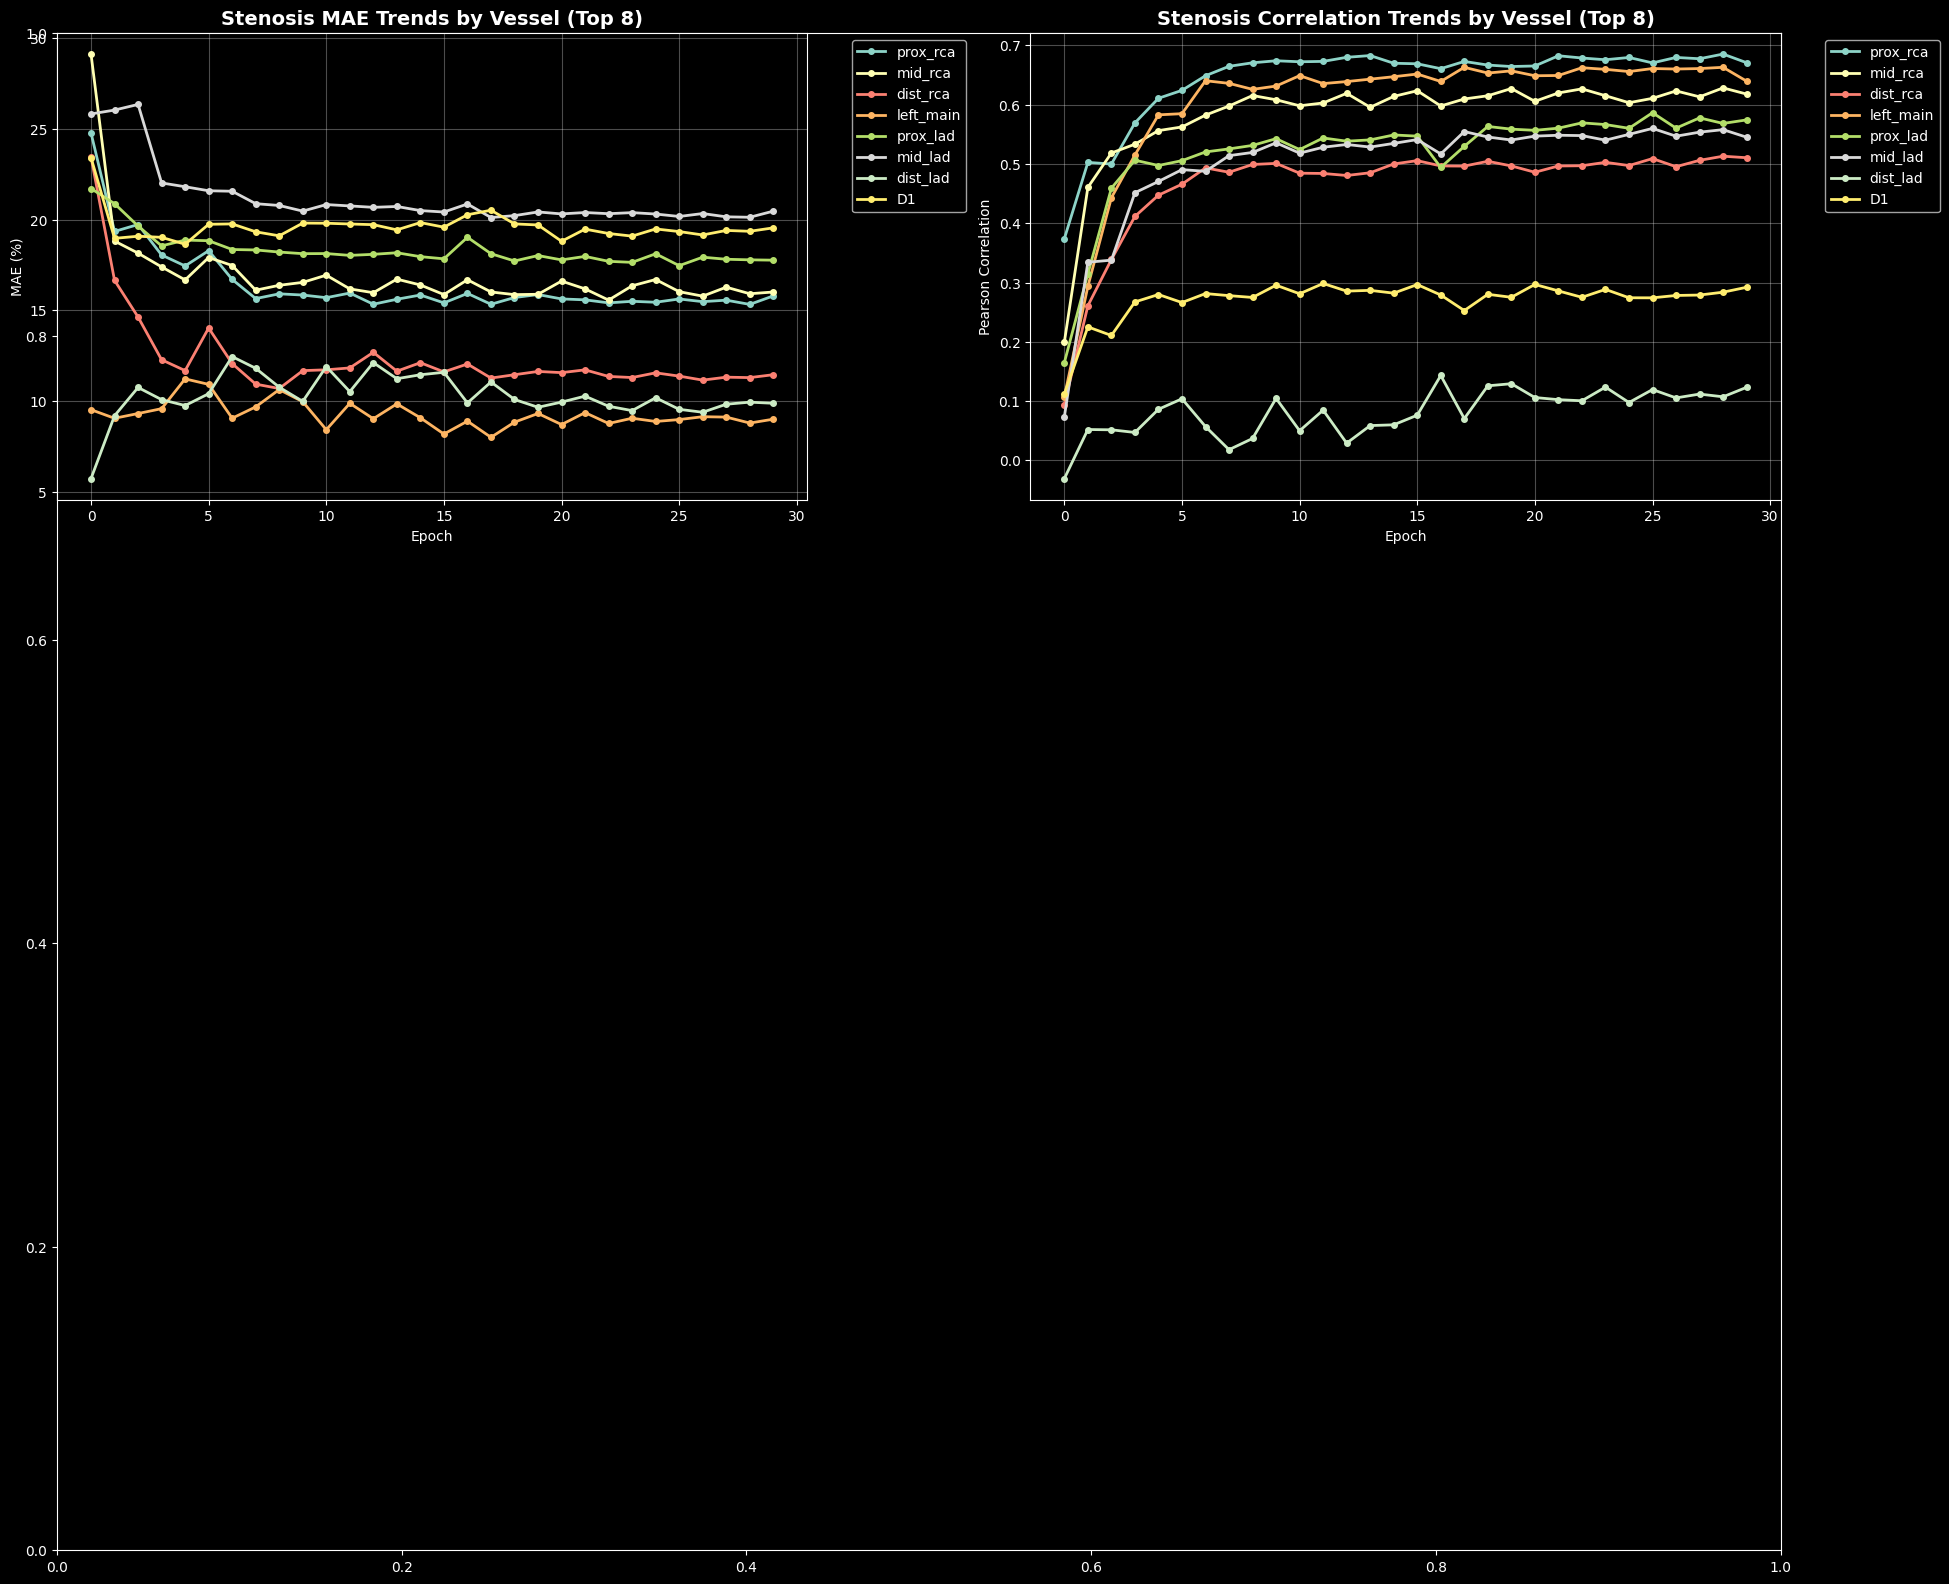

✅ Stenosis trend plots created successfully!


In [6]:
# Cell 4: Stenosis Performance Analysis
print("\n" + "="*60)
print("🫀 STEP 3: Stenosis Performance Trends")
print("="*60)

if stenosis_metrics and epoch_nums:
    from utils.plot_metrics import plot_stenosis_trends
    plot_stenosis_trends(stenosis_metrics, epoch_nums)
else:
    print("❌ No stenosis metrics available for plotting")


In [14]:
display(calcification_metrics)

defaultdict(dict,
            {'prox_rca_stenosis': {0: {'accuracy': nan},
              1: {'accuracy': nan},
              2: {'accuracy': nan},
              3: {'accuracy': nan},
              4: {'accuracy': nan},
              5: {'accuracy': nan},
              6: {'accuracy': nan},
              7: {'accuracy': nan},
              8: {'accuracy': nan},
              9: {'accuracy': nan},
              10: {'accuracy': nan},
              11: {'accuracy': nan},
              12: {'accuracy': nan},
              13: {'accuracy': nan},
              14: {'accuracy': nan},
              15: {'accuracy': nan},
              16: {'accuracy': nan},
              17: {'accuracy': nan},
              18: {'accuracy': nan},
              19: {'accuracy': nan},
              20: {'accuracy': nan},
              21: {'accuracy': nan},
              22: {'accuracy': nan},
              23: {'accuracy': nan},
              24: {'accuracy': nan},
              25: {'accuracy': nan},
         


🦴 STEP 4: Calcification Performance Analysis
🦴 Creating calcification accuracy visualizations...


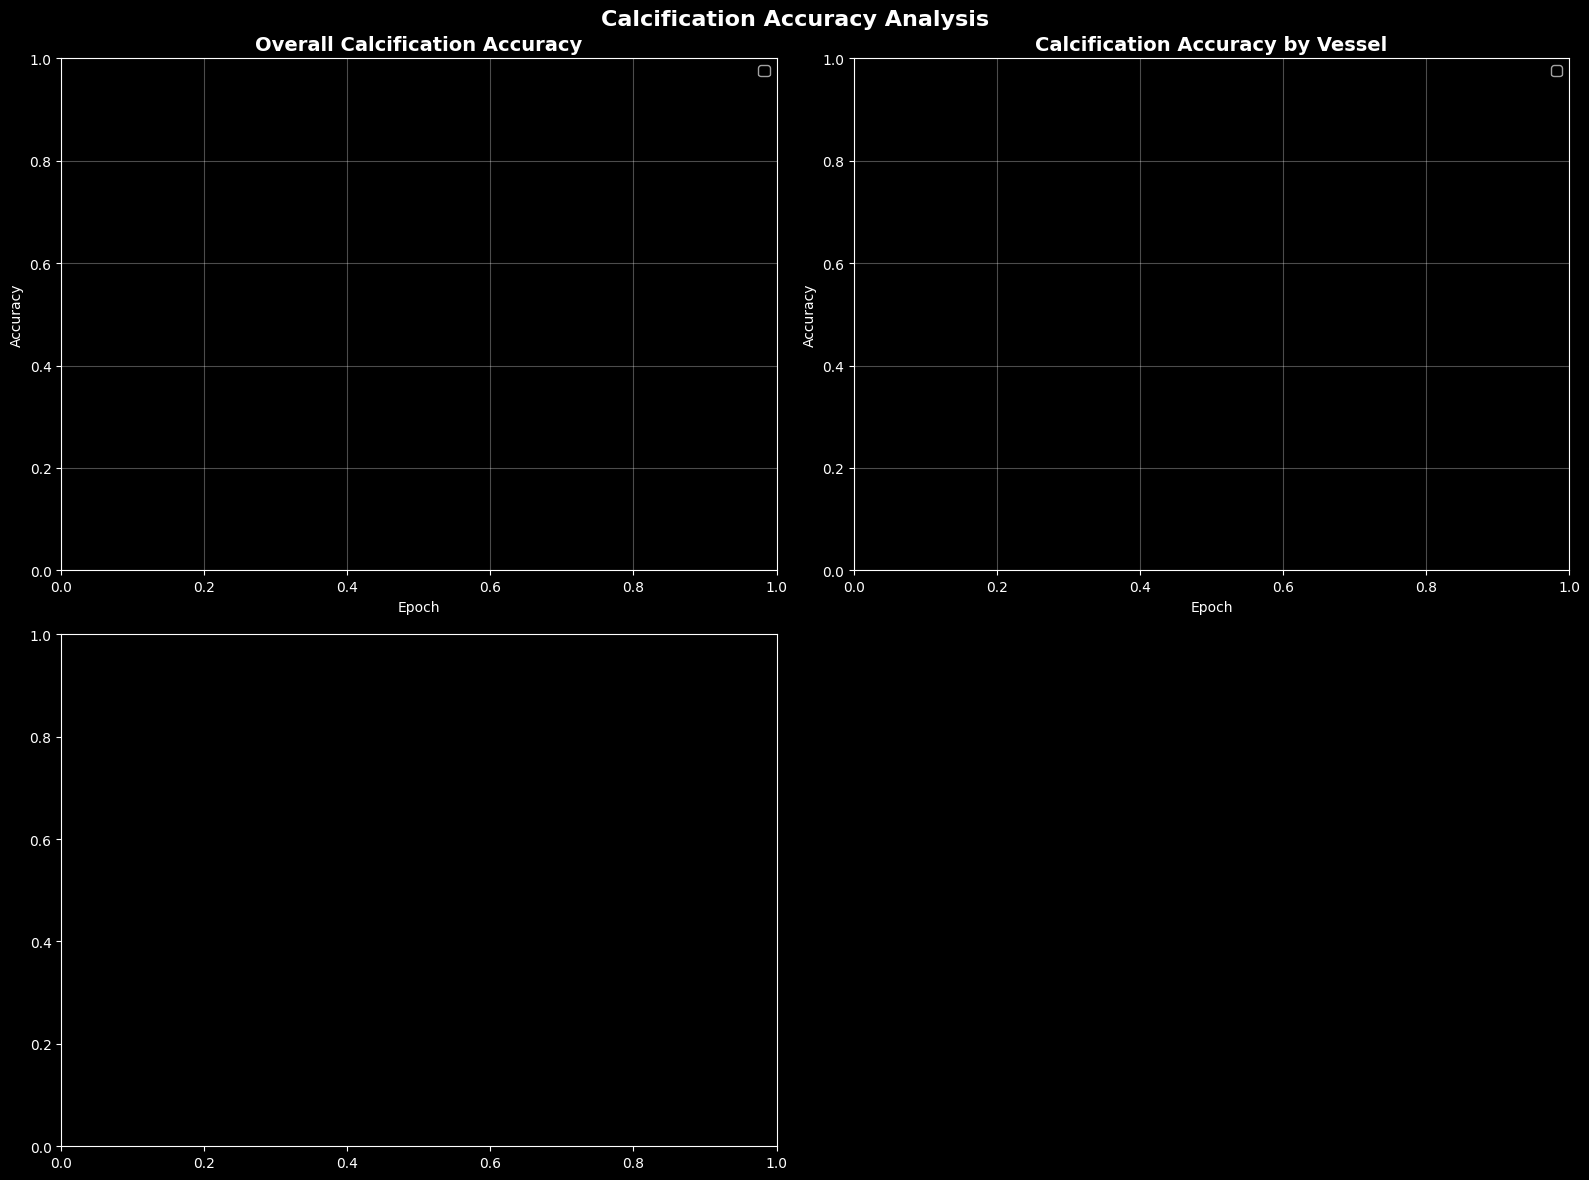

✅ Calcification plots created successfully!


In [10]:
# Cell 5: Calcification Performance Analysis
print("\n" + "="*60)
print("🦴 STEP 4: Calcification Performance Analysis")
print("="*60)

if calcification_metrics and epoch_nums:
    from utils.plot_metrics import plot_calcification_trends
    plot_calcification_trends(calcification_metrics, epoch_nums)
else:
    print("❌ No calcification metrics available for plotting")


In [11]:
# Cell 6: IFR Performance Analysis
print("\n" + "="*60)
print("💉 STEP 5: IFR Performance Analysis")
print("="*60)

if ifr_metrics and epoch_nums:
    from utils.plot_metrics import plot_ifr_trends
    plot_ifr_trends(ifr_metrics, epoch_nums)
else:
    print("❌ No IFR metrics available for plotting")



💉 STEP 5: IFR Performance Analysis
💉 Creating IFR performance visualizations...
❌ No valid IFR MAE values to plot



📊 STEP 6: Combined Performance Analysis
📊 Creating combined performance analysis...


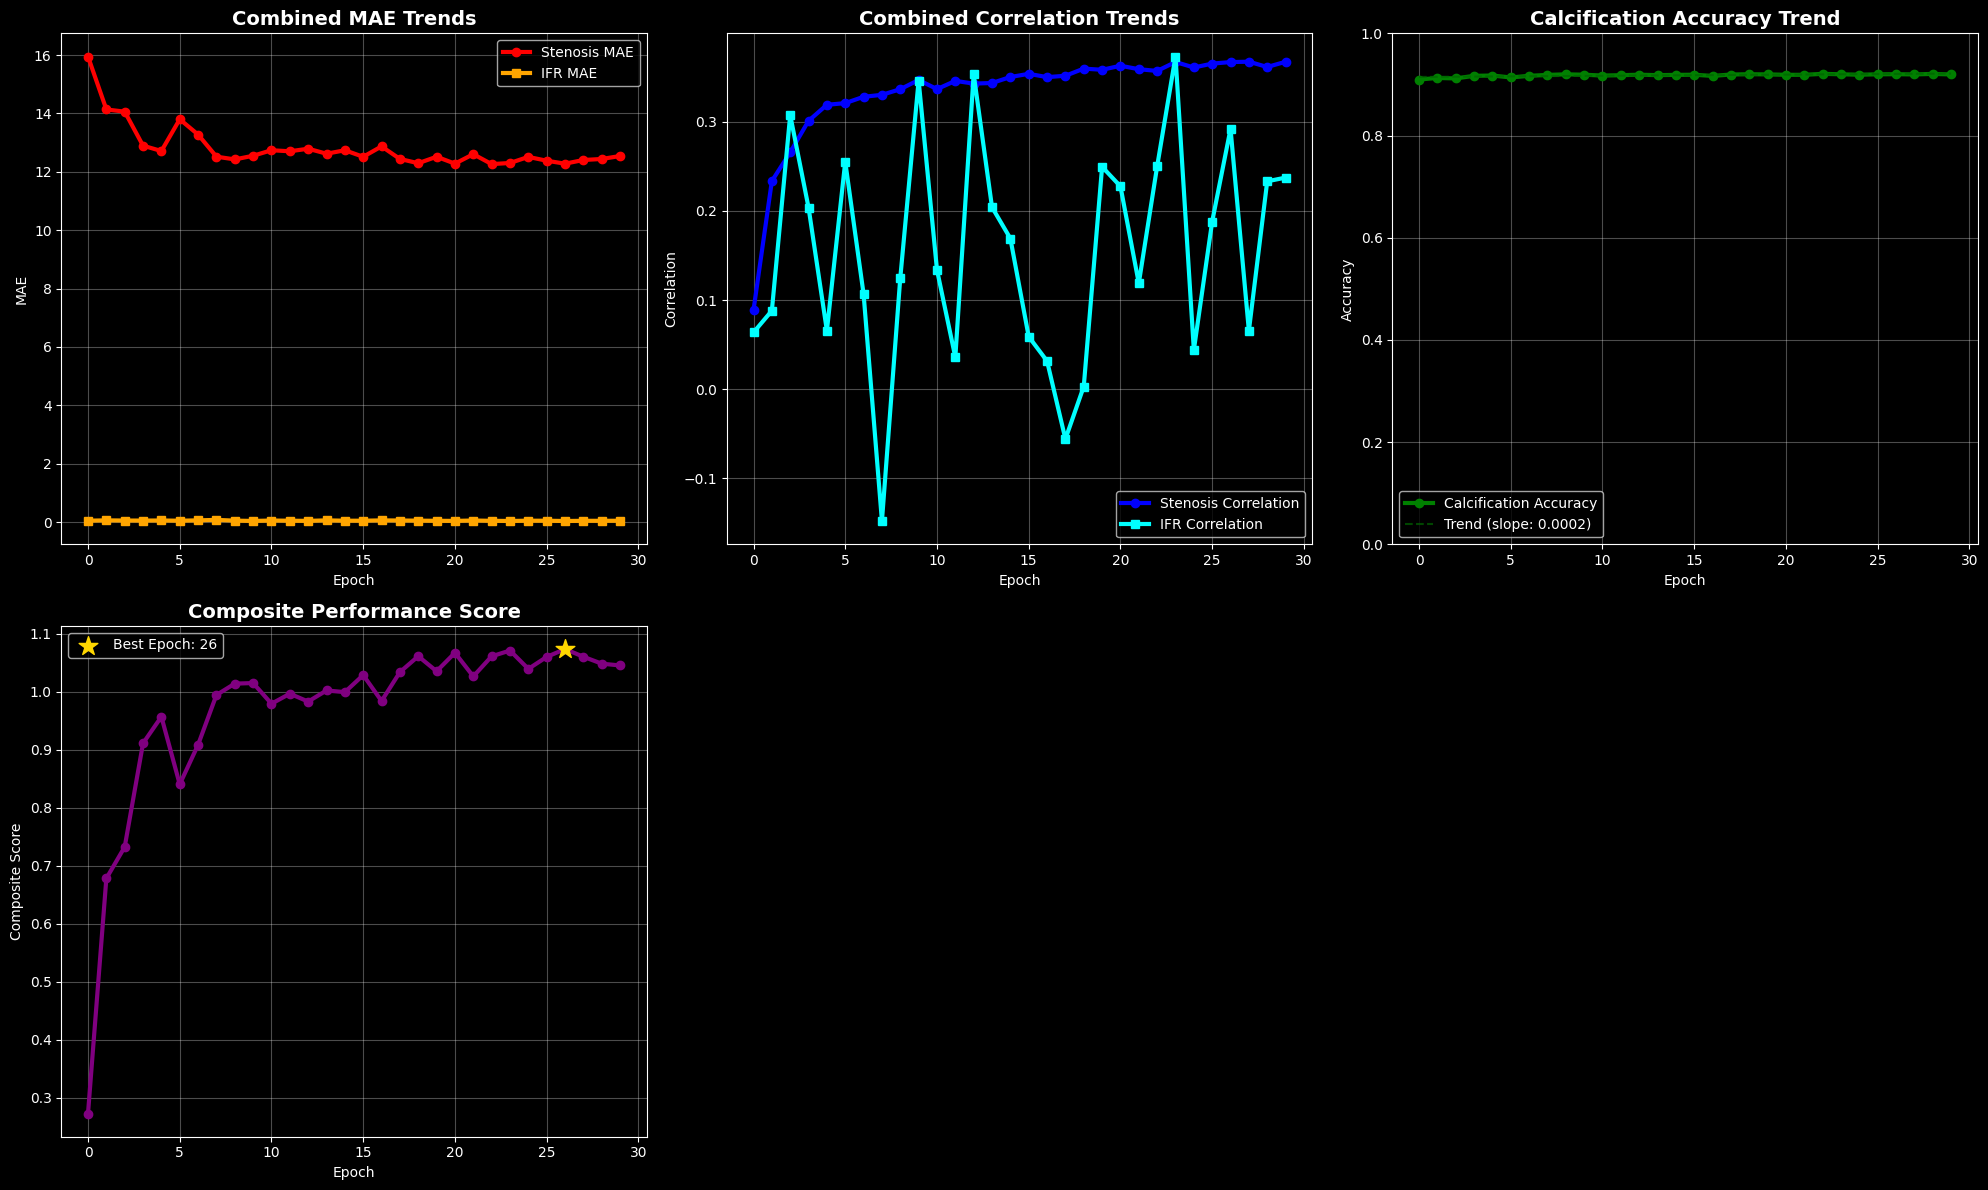


📊 COMPREHENSIVE SUMMARY:
   🏆 Best Overall Epoch: 26 (Score: 1.074)
   📈 Stenosis: MAE 12.28%, Corr 0.367
   🦴 Calcification: Accuracy 0.920
   💉 IFR: MAE 0.0350, Corr 0.292
   💾 Combined results saved: multi_epoch_study_analysis_results/combined_analysis_results.pkl


In [12]:
# Cell 7: Combined Performance Analysis
print("\n" + "="*60)
print("📊 STEP 6: Combined Performance Analysis")
print("="*60)

if all_epoch_metrics and epoch_nums:
    from utils.plot_metrics import create_combined_performance_analysis
    combined_results = create_combined_performance_analysis(all_epoch_metrics, epoch_nums)
    
    # Save results
    if combined_results:
        summary_file = os.path.join(OUTPUT_DIR, "combined_analysis_results.pkl")
        with open(summary_file, 'wb') as f:
            pickle.dump(combined_results, f)
        print(f"   💾 Combined results saved: {summary_file}")
else:
    print("❌ No epoch metrics available for combined analysis!")


In [15]:
# Cell 8: Calcification by Severity Analysis (Debug Version)
print("\n" + "="*60)
print("🔍 STEP 7: Calcification by Severity Analysis")
print("="*60)

if all_epoch_metrics and epoch_nums:
    from utils.plot_metrics import debug_calcification_by_severity
    severity_results = debug_calcification_by_severity(all_epoch_metrics, epoch_nums)
    
    # Save severity analysis results
    if severity_results:
        severity_file = os.path.join(OUTPUT_DIR, "calcification_severity_analysis.pkl")
        with open(severity_file, 'wb') as f:
            pickle.dump(severity_results, f)
        print(f"   💾 Severity analysis saved: {severity_file}")
else:
    print("❌ No calcification data available for severity analysis")



🔍 STEP 7: Calcification by Severity Analysis

🔍 DEBUGGING CALCIFICATION BY SEVERITY ANALYSIS
🔍 Step 1: Examining actual calcification metric names...

📋 Found 17 calcification metrics in epoch 0:
    1. D1_calcif: 0.891
    2. D2_calcif: 0.944
    3. bx_calcif: 0.967
    4. dist_lad_calcif: 0.969
    5. dist_lcx_calcif: 0.985
    6. dist_rca_calcif: 0.921
    7. left_main_calcif: 0.938
    8. lvp_calcif: 0.997
    9. mid_lad_calcif: 0.811
   10. mid_rca_calcif: 0.772
   11. om1_calcif: 0.948
   12. om2_calcif: 0.935
   13. pda_calcif: 0.913
   14. posterolateral_calcif: 0.955
   15. prox_lad_calcif: 0.839
   16. prox_lcx_calcif: 0.887
   17. prox_rca_calcif: 0.790

🔍 Step 2: Searching for severity patterns in ALL epochs...

📊 Total unique calcification metrics across all epochs: 17

🔍 Step 3: Detailed pattern matching analysis...

🔍 Analyzing: 'D1_calcif'
   ✅ MATCH: MILD (pattern: '1_calcif')

🔍 Analyzing: 'D2_calcif'
   ✅ MATCH: MODERATE (pattern: '2_calcif')

🔍 Analyzing: 'bx_calci

In [16]:
# Cell 9: Save Variables for Standalone Script
print("\n" + "="*60)
print("💾 STEP 8: Saving Variables for Standalone Script")
print("="*60)

# Save the key variables to pickle files for standalone script usage
import pickle
import os

# Create variables directory
variables_dir = os.path.join(OUTPUT_DIR, "saved_variables")
os.makedirs(variables_dir, exist_ok=True)

# Save key variables
variables_to_save = {
    'all_epoch_metrics': all_epoch_metrics,
    'epoch_nums': epoch_nums,
    'stenosis_metrics': stenosis_metrics,
    'calcification_metrics': calcification_metrics,
    'ifr_metrics': ifr_metrics,
    'OUTPUT_DIR': OUTPUT_DIR
}

for var_name, var_data in variables_to_save.items():
    if var_data is not None and len(var_data) > 0:
        save_path = os.path.join(variables_dir, f"{var_name}.pkl")
        with open(save_path, 'wb') as f:
            pickle.dump(var_data, f)
        print(f"   ✅ Saved {var_name}: {save_path}")
        
        # Print some info about the saved data
        if isinstance(var_data, dict):
            print(f"      📊 Dictionary with {len(var_data)} keys")
        elif isinstance(var_data, list):
            print(f"      📊 List with {len(var_data)} items")
        else:
            print(f"      📊 Data type: {type(var_data)}")
    else:
        print(f"   ❌ Skipped {var_name}: empty or None")

print(f"\n🎯 Variables saved to: {variables_dir}")
print("📝 You can now use the standalone script for debugging!")



💾 STEP 8: Saving Variables for Standalone Script
   ✅ Saved all_epoch_metrics: multi_epoch_study_analysis_results/saved_variables/all_epoch_metrics.pkl
      📊 Dictionary with 30 keys
   ✅ Saved epoch_nums: multi_epoch_study_analysis_results/saved_variables/epoch_nums.pkl
      📊 List with 30 items
   ✅ Saved stenosis_metrics: multi_epoch_study_analysis_results/saved_variables/stenosis_metrics.pkl
      📊 Dictionary with 15 keys
   ✅ Saved calcification_metrics: multi_epoch_study_analysis_results/saved_variables/calcification_metrics.pkl
      📊 Dictionary with 15 keys
   ✅ Saved ifr_metrics: multi_epoch_study_analysis_results/saved_variables/ifr_metrics.pkl
      📊 Dictionary with 15 keys
   ✅ Saved OUTPUT_DIR: multi_epoch_study_analysis_results/saved_variables/OUTPUT_DIR.pkl
      📊 Data type: <class 'str'>

🎯 Variables saved to: multi_epoch_study_analysis_results/saved_variables
📝 You can now use the standalone script for debugging!
